# Préparation et analyse des données 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.interpolate import interp1d
import datetime


## Import des données

Les données sont contenues dans 3 fichiers : 
- le fichier `rte.csv` qui contient la consommation d'électricité relevée toutes les demi-heures
- le fichier `calendar.csv` qui contient plusieures informations sur le temps
- le fichier `meteo.csv` qui contient les informations liées à la méteo, notamment l'emplacement des stations et les différents relevés (température, nebulosité, humidité, vitesse du vent, précipitation), pris toutes les 3 heures.  

In [2]:
# Import data
path = 'data/'

# Import Consumption data
rte = pd.read_csv(path + "rte.csv", sep=",")
rte = rte.dropna(subset=["Consommation"])
rte = rte[["DateTime", "Consommation"]]
rte["DateTime"] = pd.to_datetime(rte["DateTime"], format="%Y-%m-%d %H:%M:%S", utc=True)

# Import Calendar data
calendar = pd.read_csv(path + "calendar.csv", sep=";", decimal=",")
calendar["DateTime"] = pd.to_datetime(calendar["DateTime"], format="%Y-%m-%d %H:%M:%S", utc=True)

# Import meteo data
meteo = pd.read_csv(path + "meteo.csv", sep=";", decimal=",")
meteo["DateTime"] = pd.to_datetime(meteo["DateTime"], format="%Y-%m-%d %H:%M:%S", utc=True)

In [3]:
rte.head()

,DateTime,Consommation
0,2012-01-01 00:00:00+00:00,58315.0
1,2012-01-01 00:30:00+00:00,58315.0
2,2012-01-01 01:00:00+00:00,56231.0
3,2012-01-01 01:30:00+00:00,56075.0
4,2012-01-01 02:00:00+00:00,55532.0


In [4]:
calendar.head()

,DateTime,PositionDansAnnee,Mois,DemiHeure,Jour,JourFerie,JourFerieType,VacancesZoneA,VacancesZoneB,VacancesZoneC
0,2012-01-01 00:00:00+00:00,0.000000,janvier,0,dimanche,True,1janvier,True,True,True
1,2012-01-01 00:30:00+00:00,0.000057,janvier,1,dimanche,True,1janvier,True,True,True
2,2012-01-01 01:00:00+00:00,0.000114,janvier,2,dimanche,True,1janvier,True,True,True
3,2012-01-01 01:30:00+00:00,0.000171,janvier,3,dimanche,True,1janvier,True,True,True
4,2012-01-01 02:00:00+00:00,0.000228,janvier,4,dimanche,True,1janvier,True,True,True


In [5]:
meteo.head()

,DateTime,Station,IdStation,Temperature,Nebulosity,Humidity,WindSpeed,Precipitation
0,2012-01-01 00:00:00+00:00,ABBEVILLE,7005,12.0,NaN,90.0,7.2,0.0
1,2012-01-01 00:00:00+00:00,LILLE-LESQUIN,7015,12.1,100.0,88.0,7.7,0.0
2,2012-01-01 00:00:00+00:00,PTE DE LA HAGUE,7020,12.4,100.0,98.0,10.3,0.0
3,2012-01-01 00:00:00+00:00,CAEN-CARPIQUET,7027,12.9,100.0,91.0,7.2,0.0
4,2012-01-01 00:00:00+00:00,ROUEN-BOOS,7037,11.4,100.0,98.0,4.6,0.2


## Aggregation des données

Nous regroupons les informations venants des trois fichiers en un seul dataframe, que nous allons sauvegarder dans un fichier `data.csv`. Certains choix sont fait : 
- Sélection des stations méteo de la metropole
- Regroupement des relevés de température, nébulosité, humidité, vitesse du vent, précipitations, en appliquant la moyenne sur les villes, et en interpolant linéairement sur les points manquants
- La période observée va du 1er janvier 2016 au 1er juin 2023

- Ajout d'une colonne `Vacances` indiquant combien de zones sont en vacances à la date observée (valeur dans {0,1,2,3})


In [6]:
meteo["Station"].nunique()

62

In [7]:
stationsMetropole = [
    "ABBEVILLE", "LILLE-LESQUIN", "PTE DE LA HAGUE", "CAEN-CARPIQUET",
    "ROUEN-BOOS", "BREST-GUIPAVAS", "PLOUMANAC'H", "RENNES-ST JACQUES",
    "ALENCON", "ORLY", "TROYES-BARBEREY", "NANCY-OCHEY", "STRASBOURG-ENTZHEIM",
    "BELLE ILE-LE TALUT", "NANTES-BOUGUENAIS", "TOURS", "BOURGES",
    "DIJON-LONGVIC", "BALE-MULHOUSE", "PTE DE CHASSIRON", "POITIERS-BIARD",
    "LIMOGES-BELLEGARDE", "CLERMONT-FD", "LE PUY-LOUDES", "LYON-ST EXUPERY",
    "BORDEAUX-MERIGNAC", "GOURDON", "MILLAU", "MONTELIMAR",
    "MONT-DE-MARSAN", "TARBES-OSSUN", "ST GIRONS", "TOULOUSE-BLAGNAC",
    "MONTPELLIER", "MARIGNANE", "CAP CEPET", "NICE", "PERPIGNAN"
]

print(len(stationsMetropole))

# RMQ j'ai enleve EMBRUN parce que la nebulosité n'avait que des NaN 

38


In [8]:
meteo = meteo[meteo["Station"].isin(stationsMetropole)]

In [9]:
meteo_mean = meteo.groupby("DateTime").agg(
    Temperature=pd.NamedAgg(column="Temperature", aggfunc="mean"),
    Nebulosity=pd.NamedAgg(column="Nebulosity", aggfunc="mean"),
    Humidity=pd.NamedAgg(column="Humidity", aggfunc="mean"),
    WindSpeed=pd.NamedAgg(column="WindSpeed", aggfunc="mean"),
    Precipitation=pd.NamedAgg(column="Precipitation", aggfunc="mean")).reset_index()
meteo_mean

,DateTime,Temperature,Nebulosity,Humidity,WindSpeed,Precipitation
0,2012-01-01 00:00:00+00:00,11.594737,96.730769,90.789474,5.534211,0.264865
1,2012-01-01 03:00:00+00:00,11.363158,86.551724,91.736842,5.123684,0.281081
2,2012-01-01 06:00:00+00:00,11.057895,83.710526,92.789474,4.613158,0.273684
3,2012-01-01 09:00:00+00:00,11.613158,86.842105,91.578947,4.952632,0.342105
4,2012-01-01 12:00:00+00:00,13.444737,79.852941,84.710526,5.331579,0.610526
...,...,...,...,...,...,...
33331,2023-06-22 03:00:00+00:00,18.319444,93.640000,89.277778,2.972973,1.588889
33332,2023-06-22 06:00:00+00:00,19.140000,93.227273,86.457143,3.166667,1.985714
33333,2023-06-22 09:00:00+00:00,21.213514,90.681818,79.108108,3.921053,0.635135
33334,2023-06-22 12:00:00+00:00,22.556757,84.090909,72.810811,4.473684,1.478378


In [10]:
meteo_features = meteo.columns.drop(['DateTime', 'Station', 'IdStation'])

In [11]:
calendar['Vacances'] = calendar['VacancesZoneA'] * 1 + calendar['VacancesZoneB'] * 1 + calendar['VacancesZoneC'] * 1
calendar['JourFerie'] = calendar['JourFerie'] * 1
calendar = calendar.drop(columns=['VacancesZoneA', 'VacancesZoneB', 'VacancesZoneC'])
calendar['MJour'] = calendar['DateTime'].dt.day # Month day (1-31)
calendar['Annee'] = calendar['DateTime'].dt.year
calendar['is.2020'] = calendar['Annee'] == 2020

In [12]:
# Merge dataframes and select data from 2016-01-01 00:00:00 to 2023-05-31 23:30:00
start_date = pd.to_datetime("2016-01-01 00:00", format="%Y-%m-%d %H:%M", utc=True)
end_date = pd.to_datetime("2023-06-01 00:00", format="%Y-%m-%d %H:%M", utc=True)

data = rte.merge(meteo_mean, on="DateTime", how="outer")
data = data.merge(calendar, on="DateTime")
data = data[(data["DateTime"] >= start_date) & (data["DateTime"] < end_date)]

# Interpolate linearly (method="linear") weather variables 
for f in meteo_features:
    data[f] = data[f].interpolate()

data = data.sort_values(by=["DateTime"])
data

,DateTime,Consommation,Temperature,Nebulosity,Humidity,WindSpeed,Precipitation,PositionDansAnnee,Mois,DemiHeure,Jour,JourFerie,JourFerieType,Vacances,MJour,Annee,is.2020
70128,2016-01-01 00:00:00+00:00,60165.0,6.702857,88.761905,91.342857,2.288571,-0.014286,0.000000,janvier,0,vendredi,1,1janvier,3,1,2016,False
70129,2016-01-01 00:30:00+00:00,58887.0,6.543372,88.474921,91.628057,2.243179,-0.011004,0.000057,janvier,1,vendredi,1,1janvier,3,1,2016,False
70130,2016-01-01 01:00:00+00:00,56678.0,6.383887,88.187937,91.913256,2.197786,-0.007722,0.000114,janvier,2,vendredi,1,1janvier,3,1,2016,False
70131,2016-01-01 01:30:00+00:00,56460.0,6.224402,87.900952,92.198456,2.152394,-0.004440,0.000171,janvier,3,vendredi,1,1janvier,3,1,2016,False
70132,2016-01-01 02:00:00+00:00,55780.0,6.064916,87.613968,92.483655,2.107001,-0.001158,0.000228,janvier,4,vendredi,1,1janvier,3,1,2016,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200107,2023-05-31 21:30:00+00:00,41786.0,17.044444,72.500000,73.527778,3.240541,0.316667,0.413437,mai,43,mercredi,0,nonFerie,0,31,2023,False
200108,2023-05-31 22:00:00+00:00,42076.0,17.044444,72.500000,73.527778,3.240541,0.316667,0.413494,mai,44,mercredi,0,nonFerie,0,31,2023,False
200109,2023-05-31 22:30:00+00:00,42402.0,17.044444,72.500000,73.527778,3.240541,0.316667,0.413551,mai,45,mercredi,0,nonFerie,0,31,2023,False
200110,2023-05-31 23:00:00+00:00,43211.0,17.044444,72.500000,73.527778,3.240541,0.316667,0.413608,mai,46,mercredi,0,nonFerie,0,31,2023,False


In [13]:
data.shape

(129984, 17)

In [14]:
data.dtypes

DateTime             datetime64[ns, UTC]
Consommation                     float64
Temperature                      float64
Nebulosity                       float64
Humidity                         float64
WindSpeed                        float64
Precipitation                    float64
PositionDansAnnee                float64
Mois                              object
DemiHeure                          int64
Jour                              object
JourFerie                          int64
JourFerieType                     object
Vacances                           int64
MJour                              int32
Annee                              int32
is.2020                             bool
dtype: object

In [15]:
data.columns

Index(['DateTime', 'Consommation', 'Temperature', 'Nebulosity', 'Humidity',
       'WindSpeed', 'Precipitation', 'PositionDansAnnee', 'Mois', 'DemiHeure',
       'Jour', 'JourFerie', 'JourFerieType', 'Vacances', 'MJour', 'Annee',
       'is.2020'],
      dtype='object')

In [16]:
data.describe()


,Consommation,Temperature,Nebulosity,Humidity,WindSpeed,Precipitation,PositionDansAnnee,DemiHeure,JourFerie,Vacances,MJour,Annee
count,129984.000000,129984.000000,129984.000000,129984.000000,129984.000000,129984.000000,129984.000000,129984.000000,129984.000000,129984.000000,129984.000000,129984.000000
mean,53169.349420,12.876669,79.349908,74.989243,3.785425,0.235392,0.483653,23.500000,0.030650,1.019572,15.724889,2019.222304
std,11784.241574,6.635658,18.664133,12.642309,1.337569,0.370348,0.289857,13.853452,0.172368,1.299358,8.797946,2.149531
min,29053.000000,-6.447368,0.000000,24.027027,1.144737,-0.031579,0.000000,0.000000,0.000000,0.000000,1.000000,2016.000000
25%,44178.750000,7.835123,73.246904,67.210526,2.800119,0.004505,0.231690,11.750000,0.000000,0.000000,8.000000,2017.000000
50%,51366.000000,12.264889,86.088911,78.027027,3.541933,0.066216,0.470461,23.500000,0.000000,0.000000,16.000000,2019.000000
75%,61285.000000,17.673629,92.058824,84.894737,4.548335,0.321564,0.735259,35.250000,0.000000,3.000000,23.000000,2021.000000
max,96272.000000,36.281081,100.346154,95.783784,10.447368,3.533333,1.000000,47.000000,1.000000,3.000000,31.000000,2023.000000


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129984 entries, 70128 to 200111
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   DateTime           129984 non-null  datetime64[ns, UTC]
 1   Consommation       129984 non-null  float64            
 2   Temperature        129984 non-null  float64            
 3   Nebulosity         129984 non-null  float64            
 4   Humidity           129984 non-null  float64            
 5   WindSpeed          129984 non-null  float64            
 6   Precipitation      129984 non-null  float64            
 7   PositionDansAnnee  129984 non-null  float64            
 8   Mois               129984 non-null  object             
 9   DemiHeure          129984 non-null  int64              
 10  Jour               129984 non-null  object             
 11  JourFerie          129984 non-null  int64              
 12  JourFerieType      129984 non-n

In [18]:
for feature in meteo_features:
    feature_by_station = meteo[['DateTime', 'Station', feature]]
    feature_by_station.loc[:,'Station'] = feature + ' ' + feature_by_station['Station']
    feature_by_station = feature_by_station.drop_duplicates(subset=['DateTime', 'Station']).pivot(index='DateTime', columns='Station', values=feature)
    feature_by_station = feature_by_station.interpolate()
    
    # Merge dataframes based on DateTime
    data = data.merge(feature_by_station, on='DateTime', how='left')

    for s in stationsMetropole:
        # Perform linear interpolation for missing values
        data[f'{feature} {s}'] = data[f'{feature} {s}'].interpolate()

In [19]:
data.isnull().values.any()


False

In [20]:
# Le format .csv est plus sur que le .pkl
data.to_csv(path + "data.csv", index=False)

In [21]:
# Le format .pkl conserve le type des données
data.to_pickle(path + "data.pkl")

## Analyse des données

Observons le tableau `data` des données aggregées .

### Saisonnalité
On remarque une saisonnalité, avec des plus fortes consommations en hiver et plus faibles en été, et une baisse des consommations, par rapport à la moyenne saisonnière, lors du printemps 2020.

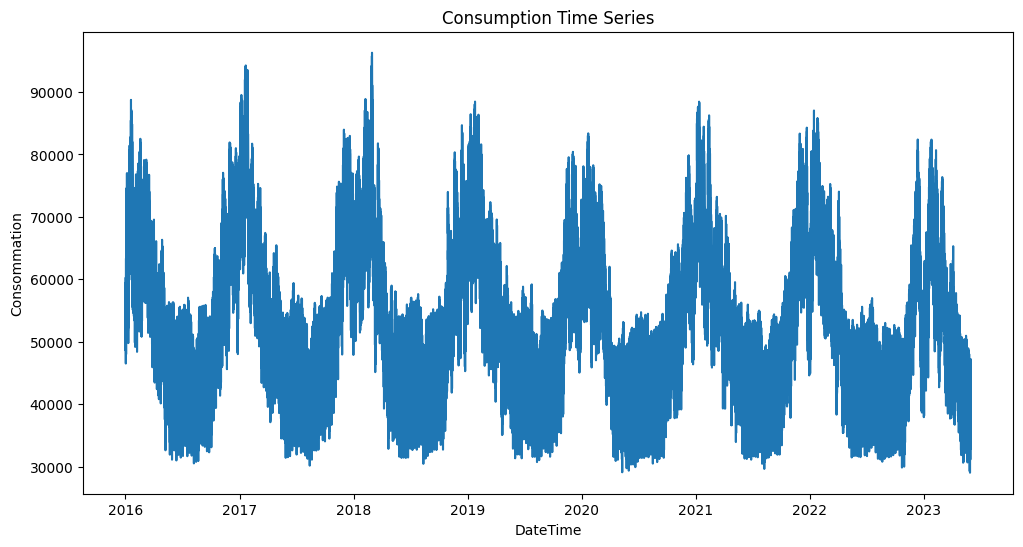

In [21]:
## Descriptive Analysis

# Plot the consumption time series
plt.figure(figsize=(12, 6))
plt.plot(data["DateTime"], data["Consommation"])
plt.xlabel("DateTime")
plt.ylabel("Consommation")
plt.title("Consumption Time Series")
plt.show()

### Profils de consommation

En groupant les données par mois, par jour, ou par demiheure, différents profils de consommation sont obersvables.
TODO redire comment on ete calculées les moyennes 

#### Profil de consommation annuel

La moyenne des consommations à l'échelle des années montre des plus fortes consommations pendant les mois d'hiver et plus faibles pendant l'été.

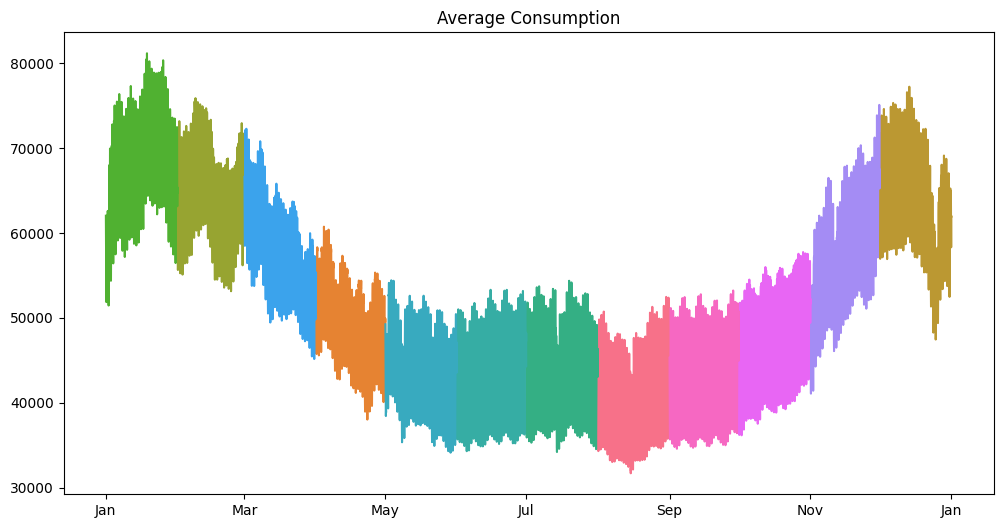

In [22]:
# Plot the annual average consumption 
monthly_avg = data.groupby(["DemiHeure", "Mois", "MJour"]).agg(Consommation=("Consommation", "mean"), DateTime =("DateTime" ,"first")).reset_index()
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x="DateTime", y="Consommation", data=monthly_avg, hue="Mois", legend=False) 
plt.xlabel("") 
plt.ylabel("")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.title("Average Consumption")
plt.show()

#### Profil de consommation hebdomadaire

La moyenne des consommations sur les semaines montre un consommation similaire les jours ouvrés et une baisse des consommation les jours fériés.

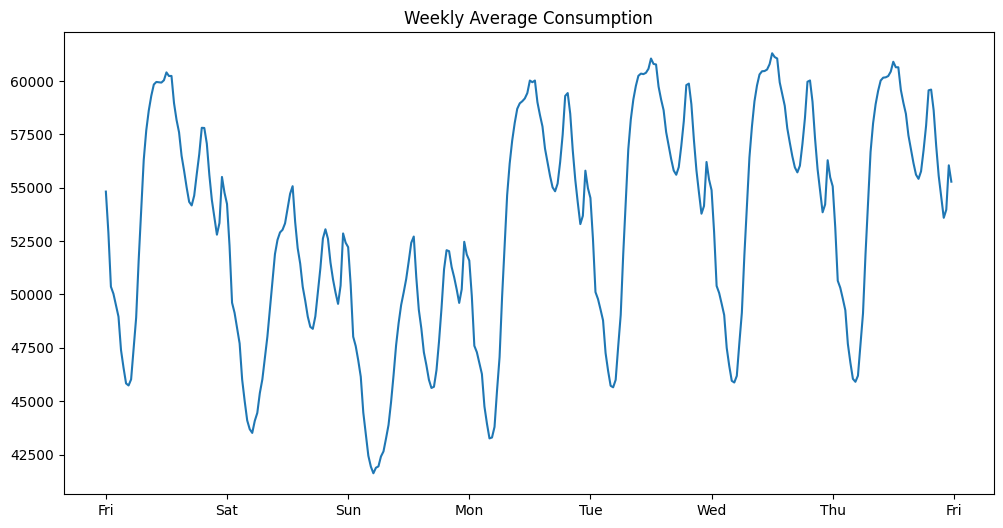

In [23]:
# Plot the Weekly average consumption
weekly_avg = data.groupby(["DemiHeure", "Jour"]).agg(Consommation=("Consommation", "mean"), DateTime =("DateTime" ,"first")).reset_index()
plt.figure(figsize=(12, 6))
ax =  sns.lineplot(x="DateTime", y="Consommation", data=weekly_avg)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a'))
plt.xlabel("")
plt.ylabel("")
plt.title("Weekly Average Consumption")
plt.show()

#### Profil de consommation journalier

Les consommations journalières ont un creux entre 4h et 5h, montent jusqu'à un premier pic autour de midi, un deuxième entre 19h et 20H et un petit pic vers 22h.


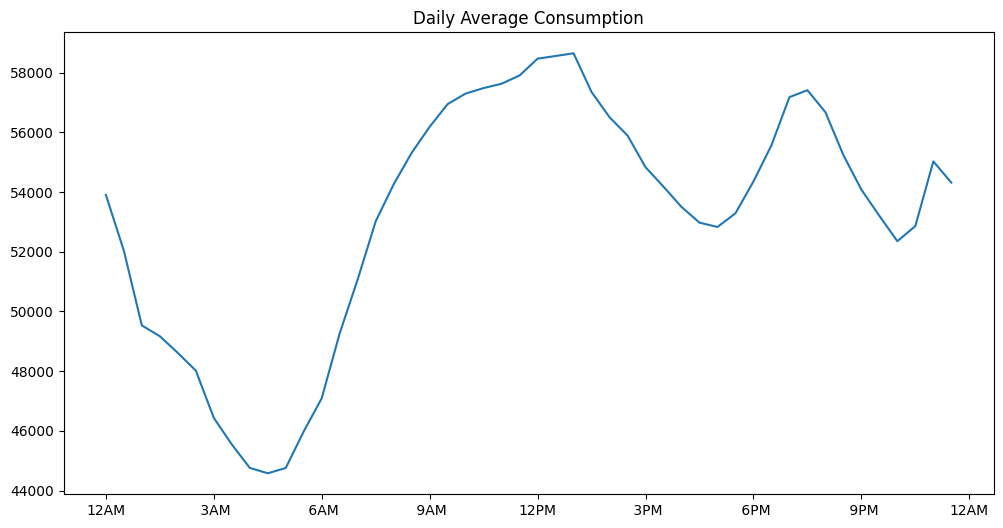

In [24]:
# Plot the Daily average consumption
daily_avg = data.groupby(["DemiHeure"]).agg(Consommation=("Consommation", "mean"), DateTime =("DateTime" ,"first")).reset_index()
plt.figure(figsize=(12, 6))
ax = sns.lineplot(x="DateTime", y="Consommation", data=daily_avg)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%l%p'))
plt.xlabel("")
plt.ylabel("")
plt.title("Daily Average Consumption")
plt.show()

### Comportements particuliers

Il est possible de mettre en évidence des petites anomalies dues au jours fériés ou au printemps 2020. 
On peut également montrer une corrélation entre consommation et données méteo. 

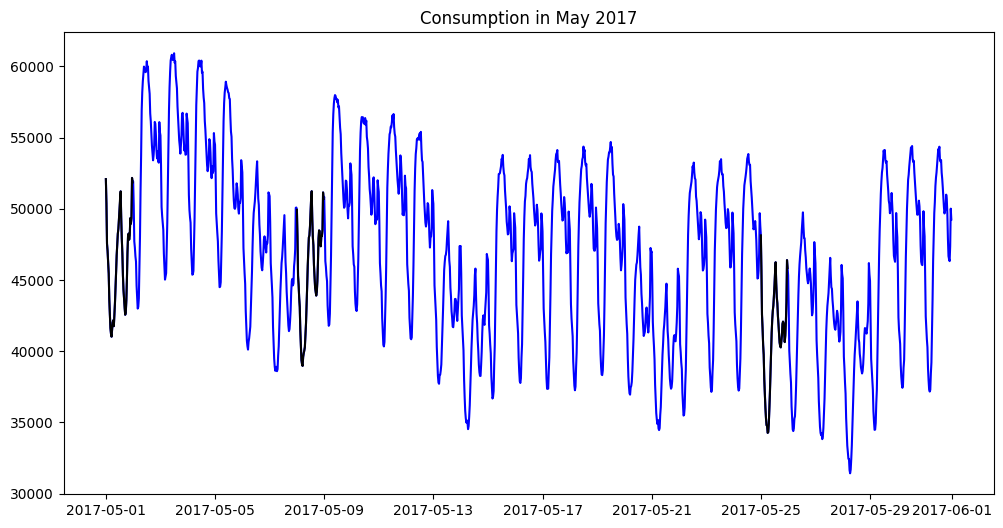

In [25]:
## Observe the consumption over particular periods (may 20217 and dec 2017- fev 2018 
## and underline bank holidays, holidays, e.g.)

# Plot the consumption for May 2017
may_2017_data = data[(data['Annee'] == 2017) & (data['Mois'] == 'mai')]
may_2017_data_1 = may_2017_data[may_2017_data['MJour'] == 1]
may_2017_data_8 = may_2017_data[may_2017_data['MJour'] == 8]
may_2017_data_25 = may_2017_data[may_2017_data['MJour'] == 25]

plt.figure(figsize=(12, 6))
plt.plot(may_2017_data['DateTime'], may_2017_data['Consommation'], color='blue')
plt.plot(may_2017_data_1['DateTime'], may_2017_data_1['Consommation'], color='black')
plt.plot(may_2017_data_8['DateTime'], may_2017_data_8['Consommation'], color='black')
plt.plot(may_2017_data_25['DateTime'], may_2017_data_25['Consommation'], color='black')
plt.xlabel('')
plt.ylabel('')
plt.title('Consumption in May 2017')
plt.show()

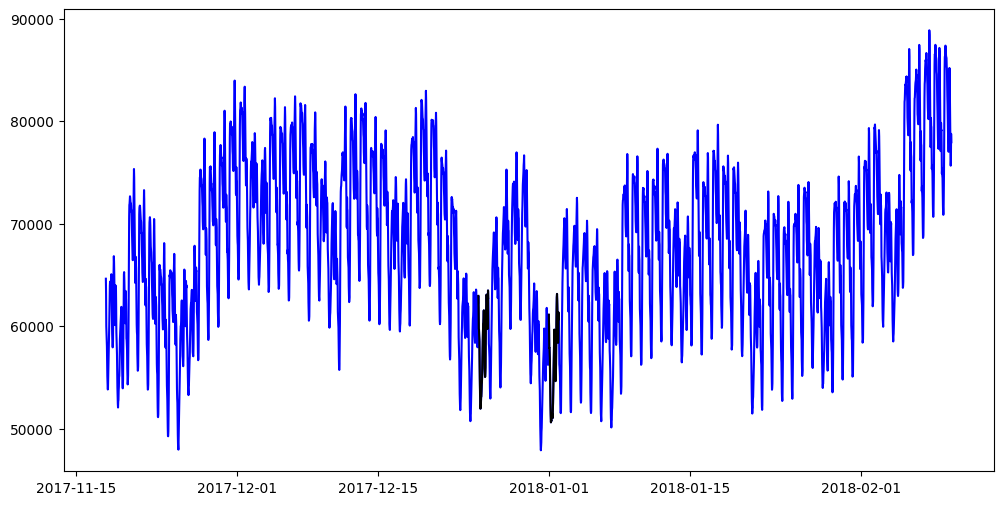

In [26]:
specified_periods_data = data[
    ((data['Annee'] == 2017) & (data['Mois'] == 'novembre') & (data['MJour'] > 17)) |
    ((data['Annee'] == 2017) & (data['Mois'] == 'décembre')) |
    ((data['Annee'] == 2018) & (data['Mois'] == 'janvier')) |
    ((data['Annee'] == 2018) & (data['Mois'] == 'février') & (data['MJour'] < 10))
]
dec25 = specified_periods_data[(specified_periods_data['JourFerie'] == True) & 
                             (specified_periods_data['Mois'] == 'décembre')]
jan01 = specified_periods_data[(specified_periods_data['JourFerie'] == True) & 
                             (specified_periods_data['Mois'] == 'janvier')]
plt.figure(figsize=(12, 6))
plt.plot(specified_periods_data['DateTime'], specified_periods_data['Consommation'], color='blue')
plt.plot(dec25['DateTime'],dec25['Consommation'], color='black')
plt.plot(jan01['DateTime'],jan01['Consommation'], color='black')
plt.xlabel('')
plt.ylabel('')
plt.show()

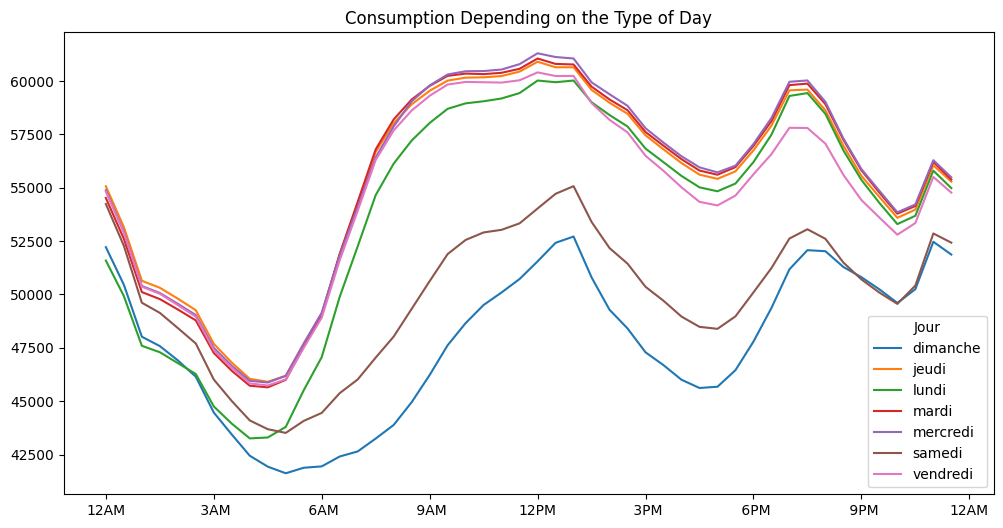

In [27]:
# Observe the consumption depending on the type of day
viz = data.groupby(["DemiHeure", "Jour"]).agg(Consommation=("Consommation", "mean"), DateTime =("DateTime" ,"first")).reset_index()
viz['DateTime'] = viz['DateTime'].apply(lambda x: x.replace(day=1))


plt.figure(figsize=(12, 6))
ax = sns.lineplot(x='DateTime', y='Consommation', hue='Jour', data=viz)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%l%p'))
plt.xlabel('')
plt.ylabel('')
plt.title('Consumption Depending on the Type of Day')
plt.show()

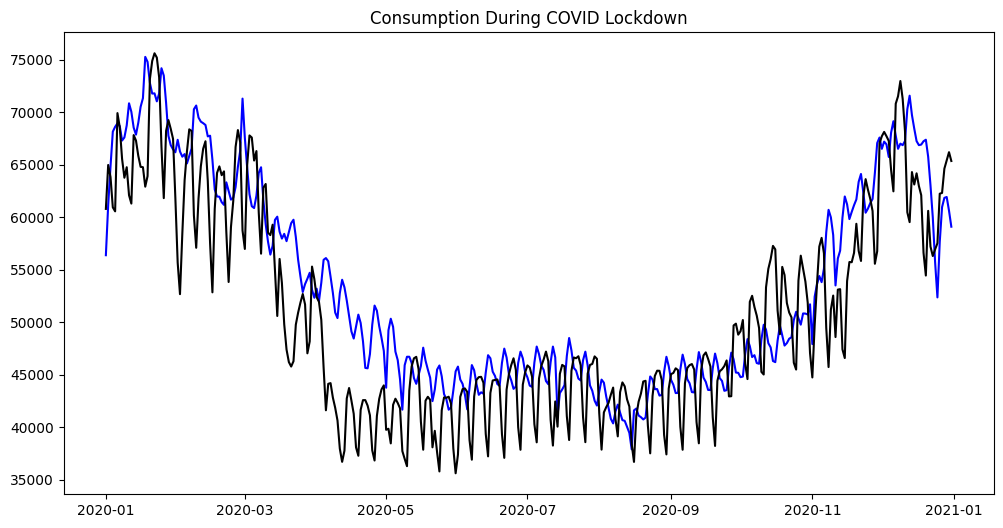

In [28]:
# Observe the consumption during the COVID lockdown
viz = data.groupby(['is.2020', "MJour","Mois"]).agg(Consommation=("Consommation", "mean"), DateTime =("DateTime" ,"first")).reset_index()

viz['DateTime'] = viz['DateTime'].apply(lambda x: x.replace(year=2020))

plt.figure(figsize=(12, 6))
sns.lineplot(x='DateTime', y='Consommation', hue='is.2020', data=viz, palette=['blue', 'black'], legend=False)
plt.xlabel('')
plt.ylabel('')
plt.title('Consumption During COVID Lockdown')
plt.show()

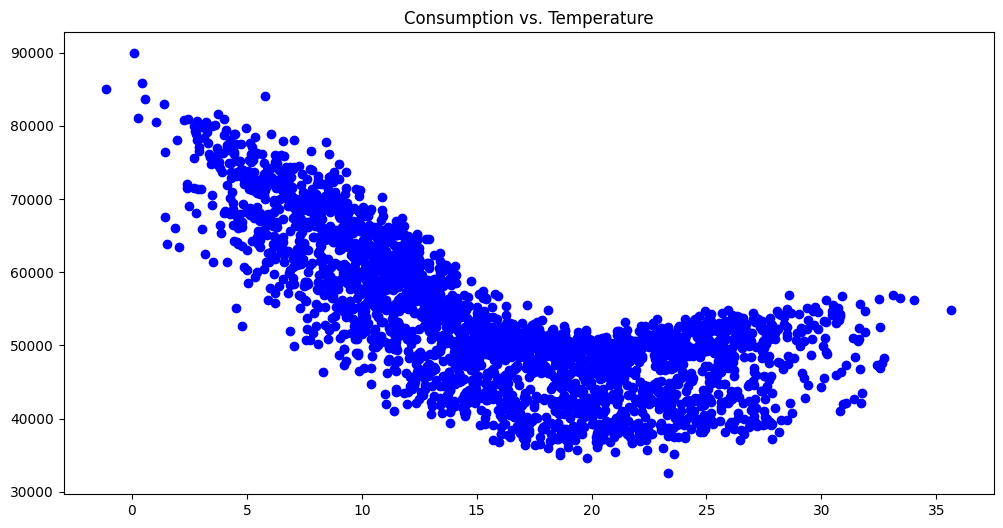

In [29]:
# Observe the consumption on some specific half-hour depending on the weather variables
temperature_data = data[data['DemiHeure'] == 32]
nebulosity_data = data[data['DemiHeure'] == 24]
humidity_data = data[data['DemiHeure'] == 24]

plt.figure(figsize=(12, 6))
plt.scatter(temperature_data['Temperature'], temperature_data['Consommation'], color='blue')
plt.xlabel('')
plt.ylabel('')
plt.title('Consumption vs. Temperature')
plt.show()

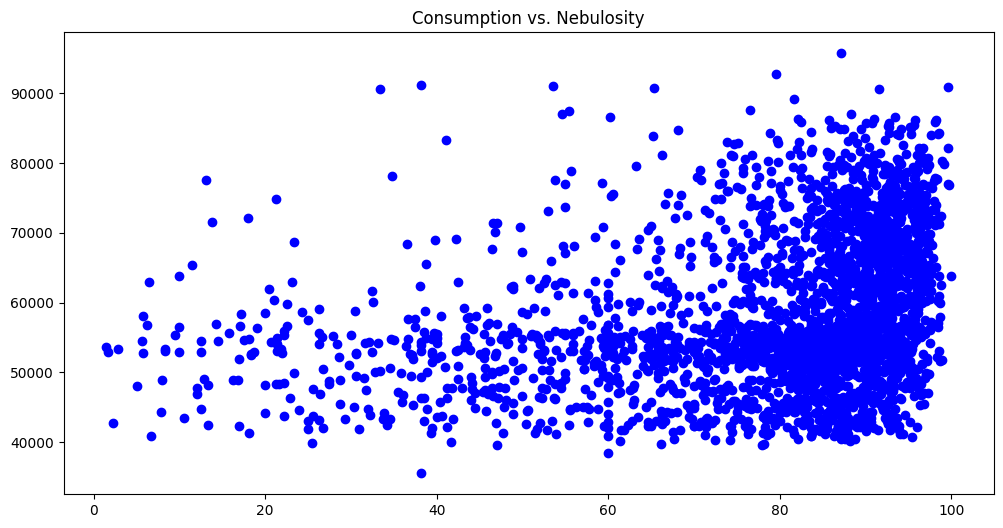

In [30]:
plt.figure(figsize=(12, 6))
plt.scatter(nebulosity_data['Nebulosity'], nebulosity_data['Consommation'], color='blue')
plt.xlabel('')
plt.ylabel('')
plt.title('Consumption vs. Nebulosity')
plt.show()

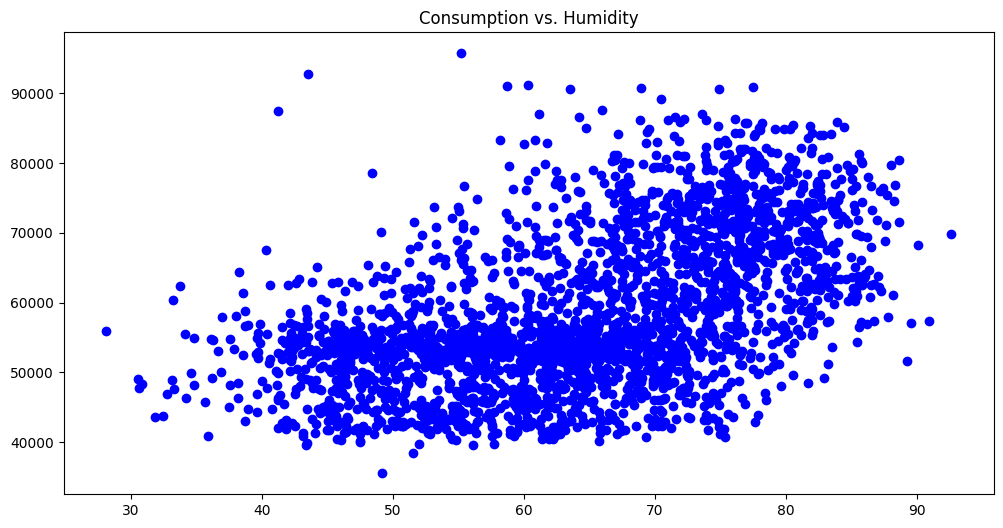

In [31]:
plt.figure(figsize=(12, 6))
plt.scatter(humidity_data['Humidity'], humidity_data['Consommation'], color='blue')
plt.xlabel('')
plt.ylabel('')
plt.title('Consumption vs. Humidity')
plt.show()

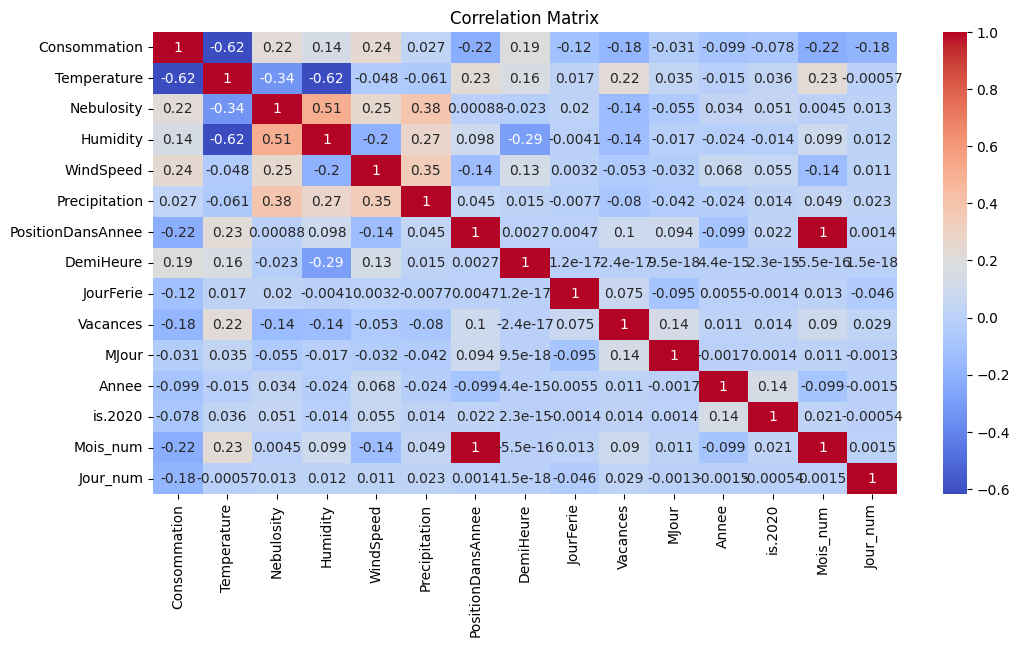

In [32]:
# Correlation matrix
data['Mois_num'] = data['DateTime'].dt.month
data['Jour_num'] = data['DateTime'].dt.weekday

cols = ['Consommation', 'Temperature', 'Nebulosity', 'Humidity', 'WindSpeed',
       'Precipitation', 'PositionDansAnnee', 'DemiHeure', 'JourFerie',
       'Vacances', 'MJour', 'Annee', 'is.2020', 'Mois_num', 'Jour_num']

mean_data = data[cols]
cormat = mean_data.corr()
melted_cormat = cormat.stack().reset_index()
melted_cormat.columns = ['Var1', 'Var2', 'value']

plt.figure(figsize=(12, 6))
sns.heatmap(cormat, annot=True, cmap='coolwarm')
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation Matrix')
plt.show()

In [45]:
# TODO 
# si je garde seulement les pivots des données meteo par ville je ne retombe pas sur les moyennes
filter_temp = [col for col in data if col.startswith('Temperature ')]
filter_temp

diff = data[filter_temp].mean(axis=1) - data["Temperature"]